In [1]:
%matplotlib inline

In [2]:
mv ckconv ckconv_old


mv: cannot stat 'ckconv': No such file or directory


In [3]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from deepsith import DeepSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random
import sys
ckconv_source =  os.path.join(os.getcwd(), join('..','..','..','ckconv'))
if ckconv_source not in sys.path:
    sys.path.append(ckconv_source)
from model import get_model

<class 'torch.cuda.FloatTensor'>


AttributeError: module 'ckconv' has no attribute 'nn'

In [4]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                    'C':'-.-.', 'D':'-..', 'E':'.', 
                    'F':'..-.', 'G':'--.', 'H':'....', 
                    'I':'..', 'J':'.---', 'K':'-.-', 
                    'L':'.-..', 'M':'--', 'N':'-.', 
                    'O':'---', 'P':'.--.', 'Q':'--.-', 
                    'R':'.-.', 'S':'...', 'T':'-', 
                    'U':'..-', 'V':'...-', 'W':'.--', 
                    'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                    '1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', ', ':'--..--', '.':'.-.-.-', 
                    '?':'..--..', '/':'-..-.', '-':'-....-', 
                    '(':'-.--.', ')':'-.--.-'} 

In [5]:
print(MORSE_CODE_DICT['?'], MORSE_CODE_DICT['?'].replace('.', '10').replace('-', '1110'))
print(len(MORSE_CODE_DICT))
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    #if len(morse_code_numpy[k]) == 12:
    #    print(morse_code_numpy[k], k)
    print(morse_code_numpy[k], k)
print(len(morse_code_numpy))
subset = list(morse_code_numpy.keys())
#subset = ['3', '7', 'Y', 'Q', 'J',
#          'M', 'R', 'U', 'H', 'D']

..--.. 1010111011101010
43
[1 0 1 1 1 0 0 0] A
[1 1 1 0 1 0 1 0 1 0 0 0] B
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] C
[1 1 1 0 1 0 1 0 0 0] D
[1 0 0 0] E
[1 0 1 0 1 1 1 0 1 0 0 0] F
[1 1 1 0 1 1 1 0 1 0 0 0] G
[1 0 1 0 1 0 1 0 0 0] H
[1 0 1 0 0 0] I
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] J
[1 1 1 0 1 0 1 1 1 0 0 0] K
[1 0 1 1 1 0 1 0 1 0 0 0] L
[1 1 1 0 1 1 1 0 0 0] M
[1 1 1 0 1 0 0 0] N
[1 1 1 0 1 1 1 0 1 1 1 0 0 0] O
[1 0 1 1 1 0 1 1 1 0 1 0 0 0] P
[1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0] Q
[1 0 1 1 1 0 1 0 0 0] R
[1 0 1 0 1 0 0 0] S
[1 1 1 0 0 0] T
[1 0 1 0 1 1 1 0 0 0] U
[1 0 1 0 1 0 1 1 1 0 0 0] V
[1 0 1 1 1 0 1 1 1 0 0 0] W
[1 1 1 0 1 0 1 0 1 1 1 0 0 0] X
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] Y
[1 1 1 0 1 1 1 0 1 0 1 0 0 0] Z
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 1
[1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 2
[1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0] 3
[1 0 1 0 1 0 1 0 1 1 1 0 0 0] 4
[1 0 1 0 1 0 1 0 1 0 0 0] 5
[1 1 1 0 1 0 1 0 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0] 7
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0]

In [6]:
id2key = subset
key2id = {}
for idx, s in enumerate(subset):
    key2id[s] = idx

X = [ttype(morse_code_numpy[k])for k in subset]
Y = torch.LongTensor(np.arange(0,len(X)))
print(Y.max())
print(X, Y)

tensor(42)
[tensor([1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 

In [7]:
class CKCNN_backbone(torch.nn.Module):
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        num_blocks: int,
        kernelnet_hidden_channels: int,
        kernelnet_activation_function: str,
        kernelnet_norm_type: str,
        dim_linear: int,
        bias: bool,
        omega_0: bool,
        dropout: float,
        weight_dropout: float,
    ):
        super().__init__()
        
        # Add num_blocks CKBlocks to a sequential called self.backbone
        blocks = []
        for i in range(num_blocks):
            block_in_channels = in_channels if i == 0 else hidden_channels
            blocks.append(
                ckconv.nn.CKBlock(
                    block_in_channels,
                    hidden_channels,
                    kernelnet_hidden_channels,
                    kernelnet_activation_function,
                    kernelnet_norm_type,
                    dim_linear,
                    bias,
                    omega_0,
                    dropout,
                    weight_dropout,
                )
            )
        self.backbone = torch.nn.Sequential(*blocks)

    def forward(self, x):
        return self.backbone(x)


class CKCNN(CKCNN_backbone):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        hidden_channels: int,
        num_blocks: int,
        kernelnet_hidden_channels: int,
        kernelnet_activation_function: str,
        kernelnet_norm_type: str,
        dim_linear: int,
        bias: bool,
        omega_0: bool,
        dropout: float,
        weight_dropout: float,
    ):
        super().__init__(
            in_channels,
            hidden_channels,
            num_blocks,
            kernelnet_hidden_channels,
            kernelnet_activation_function,
            kernelnet_norm_type,
            dim_linear,
            bias,
            omega_0,
            dropout,
            weight_dropout,
        )

        self.finallyr = torch.nn.Linear(
            in_features=hidden_channels, out_features=out_channels
        )
        # Initialize finallyr
        self.finallyr.weight.data.normal_(
            mean=0.0,
            std=0.01,
        )
        self.finallyr.bias.data.fill_(value=0.0)

    def forward(self, x):
        out = self.backbone(x)
        out = self.finallyr(out[:, :, -1])
        return out



# Three Layers

In [7]:
# Construct network:
in_channels = 1
out_channels = 43
hidden_channels = 25
num_blocks = 2
kernelnet_hidden_channels = 32
kernelnet_activation_function = 'Sine'
kernelnet_norm_type = ''
dim_linear = 1
bias = True
omega_0 = 30.5
dropout = 0.0
weight_dropout = 0.0

model = CKCNN(in_channels,
                out_channels,
                hidden_channels,
                num_blocks,
                kernelnet_hidden_channels,
                kernelnet_activation_function,
                kernelnet_norm_type,
                dim_linear,
                bias,
                omega_0,
                dropout,
                weight_dropout).cuda()

tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)
model(iv)

NameError: name 'CKCNN' is not defined

In [37]:
model(iv)

RuntimeError: shape '[-1, 1, 120]' is invalid for input of size 2000

In [36]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000
Trainscale = 10
device='cuda'
batch_size = 8
batches = int(np.ceil(43 / batch_size))

progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')
times_100 = 0

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx in range(batches):
        optimizer.zero_grad()
        loss = 0
        permute = np.arange(0, 43)
        for i in range(0, int(min(len(X) - (batch_idx*batch_size), 
                              batch_size))
                       ):
            iv = X[permute[batch_idx*batch_size + i]]
            iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
            iv = iv.repeat(1,1,1,Trainscale)
            iv = iv.reshape(1,1,-1)
            print(iv.shape)
            tv = Y[permute[batch_idx*batch_size + i]].to(device)
            out = model(iv)
            loss += loss_func(out,
                         torch.cuda.LongTensor([tv]))
            perfs.append((torch.argmax(out, dim=-1) == 
                          tv).sum().item())
            
        
        loss = loss / min(len(X) - (batch_idx*batch_size), 
                          batch_size)
        loss.backward()
        optimizer.step()

            
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]


        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)
    if (np.sum(perfs)/((len(perfs))) == 1.0) & (np.mean(losses) < .11):
        times_100 += 1
        if times_100 >= 3:
            break


torch.Size([1, 1, 80])
torch.Size([1, 1, 120])



RuntimeError: shape '[-1, 1, 120]' is invalid for input of size 2000

In [38]:
model.eval()
evald = []
evaldDict = {'test_perf':[],
             'rate':[]}
for nr in [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]:
#for nr in range(1,20):
    perfs = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(-1)
        iv = iv.repeat(1,1,1,nr)
        iv = iv.reshape(1,1,-1)
        tv = Y[batch_idx].to(device)
        out = model(iv)
        loss = loss_func(out,
                         torch.cuda.LongTensor([tv]))


        perfs.append((torch.argmax(out, dim=-1) == 
                      tv).sum().item())
        #print(torch.argmax(out, dim=-1), 
        #              tv)
    evaldDict['test_perf'].append(sum(perfs)/len(perfs))
    evaldDict['rate'].append(nr)
    print(nr, sum(perfs)/len(perfs))
    evald.append({'scale':nr, 
                  'perf':sum(perfs)/len(perfs)})
scale_perfs = pd.DataFrame(evald)
scale_perfs.to_pickle(join("perf", "tcn_morse_test.dill"))

1 0.023255813953488372
2 0.0
5 0.023255813953488372
6 0.023255813953488372
7 0.023255813953488372
8 0.023255813953488372
9 0.09302325581395349
10 1.0
11 0.3023255813953488
12 0.023255813953488372
13 0.0
14 0.0
15 0.0
16 0.023255813953488372
17 0.023255813953488372
18 0.023255813953488372
19 0.023255813953488372
20 0.023255813953488372
30 0.023255813953488372
40 0.023255813953488372


In [33]:
TCN_perfs = pd.read_pickle(join("perf", "tcn_morse_test.dill"))

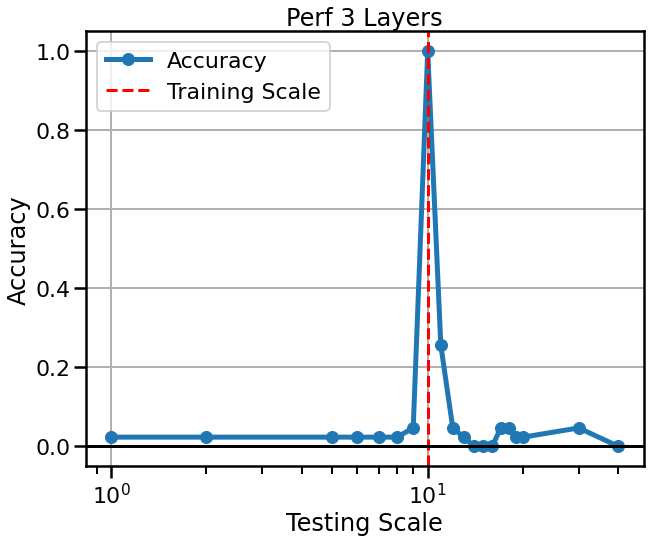

In [35]:
fig=plt.figure(figsize=(10,8))
plt.plot(TCN_perfs.scale, TCN_perfs.perf, marker='o', linewidth=5)

plt.axvline(Trainscale, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.ylim(-.05, 1.05)
plt.grid()
plt.xscale('log')
plt.title('Perf 3 Layers')
plt.ylabel('Accuracy')
plt.xlabel('Testing Scale')
plt.legend(['Accuracy', 'Training Scale'])
plt.savefig(join('figs', 'perf3layers_DeepSITH'), dpi=100)

In [20]:
import pandas as pd
dat = pd.DataFrame(evaldDict)
dat.to_csv(join('perf','DeepSITH_morse_perf.csv'))

In [30]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = args[2]
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

In [ ]:
ntau = 250
k_0 = 20
tau_min = .1
tau_max = 1000.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)

k = int(res.x)
fig = plt.figure(figsize=(12,8))

print('ntau:', ntau, 'k:', k)

(-5.0, 3000.0)

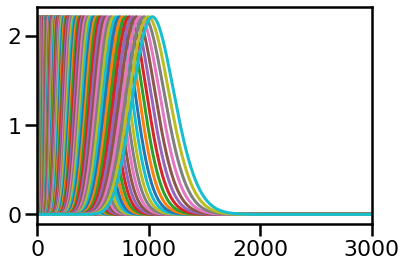

In [40]:
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, 
           k=30, ntau=ntau, dt=1.0, g=1.0)
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
#        linewidth=8, color='grey');
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
#        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
#plt.ylim(-.05, 2.1)
plt.xlim(-5, 3*tau_max)
#plt.legend(["Total Sum", "Alternating Sum"])